In [1]:
import pandas as pd 
import numpy as np
import copy 
import random
from matplotlib import pyplot as plt 
from glob import glob
import re
import nltk
from numpy.linalg import norm
from scipy.spatial.distance import pdist
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stop = stopwords.words('english')
from nltk import pos_tag
import scipy.cluster.hierarchy as sch
import ipywidgets as widgets
import networkx as nx
from IPython.display import display

In [2]:
# spefcify the path
path     = '/Users/philhuang/Desktop/Phil_projects/Patent-main/workdata/'
rst_path = '/Users/philhuang/Desktop/Phil_projects/Patent-main/results/'

In [3]:
# read in the citation and abstract data
pooling_patent_data = pd.read_csv(path+'pooling_patent_data_filter.csv')
pooling_patent_data

,Patent_ID,Patent_abstract,cleaned_and_stemmed_nouns_verbs_abstract
0,CN98118142.2,A Chinese patent medicine in the form of capsu...,patent medicin form capsul is prepar chiretta ...
1,CN200710126165.3,The invention discloses a method and apparatus...,invent disclos method apparatu hide data packa...
2,CN200610060717.0,The method comprises: receiving an audio signa...,method compris receiv signal signal sourc get ...
3,CN00103340.9,A device for eliminating the mini ice crystal ...,devic elimin mini ice crystal supercool water ...
4,CN200710075612.7,The invention provides a method of producing s...,invent provid method produc effect calcul part...
...,...,...,...
263667,JPH0217849,PURPOSE: To facilitate stopping rotation of a ...,purpos facilit stop rotat rotor open hole posi...
263668,WO2005017670A,"An embodiment of the invention, for controllin...",embodi invent control context menu use web pag...
263669,DE202005008280U,A radial fan (20) has an impeller (22) enclose...,fan ha impel enclos case air inlet air inlet o...
263670,KR100211453B,AbstractTranslated from Korean The remote cont...,abstracttransl korean control lock unlock devi...


### 1）Distribution of original abstract length:

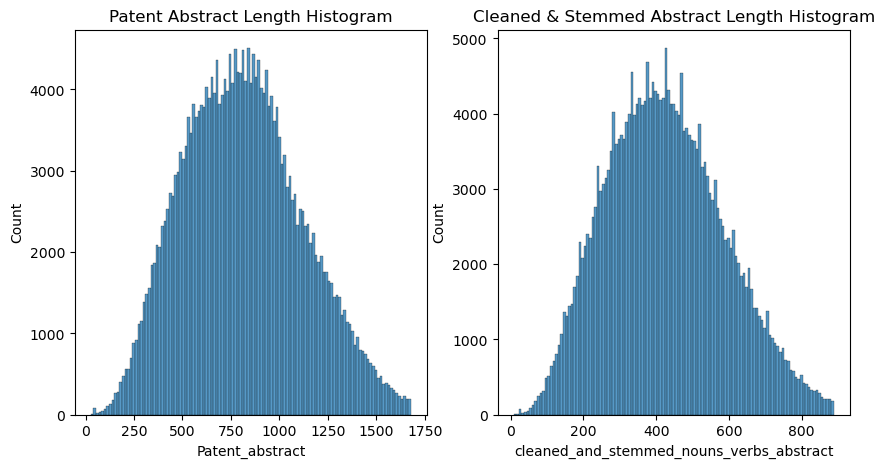

In [4]:
###Outliers are defined as data points that are more than 1.5 times the IQR away from the upper or lower quartile.
import seaborn as sns
import matplotlib.pyplot as plt

def draw_len_hist(ax, data, column):
    Q1 = data[column].str.len().quantile(0.25)
    Q3 = data[column].str.len().quantile(0.75)
    IQR = Q3 - Q1
    # Calculate the upper and lower bounds
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    # Filter out the outliers
    filtered_data = data.loc[data[column].str.len().between(lower_bound, upper_bound)]
    # Plot the histogram of the filtered data
    return sns.histplot(filtered_data[column].str.len(), ax=ax)

# Create a 1x2 grid of plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Draw histograms
draw_len_hist(ax1, pooling_patent_data, 'Patent_abstract')
draw_len_hist(ax2, pooling_patent_data, 'cleaned_and_stemmed_nouns_verbs_abstract')

# Set titles for the histograms
ax1.set_title('Patent Abstract Length Histogram')
ax2.set_title('Cleaned & Stemmed Abstract Length Histogram')

# Show the combined plots
plt.savefig(rst_path+'length.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

### 2） Load a distance table

In [8]:
# read in the distance calculated based on the tfidf table
distance_tfidf_df = pd.read_csv(path+'distance_tfidf_df.csv').set_index(['APPLN_ID_SIPO', 'PubNum_google'])
distance_tfidf_df = distance_tfidf_df.replace([float('inf')], np.nan)
distance_tfidf_df_valid = distance_tfidf_df.dropna().reset_index()
distance_tfidf_df_valid

,APPLN_ID_SIPO,PubNum_google,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
0,CN200710048659.4,CN100390228C,1.272701,0.809884,0.755645,0.911111
1,CN200710048659.4,CN1145295A,1.071938,0.574525,0.692075,0.875000
2,CN200710048659.4,CN1250621C,1.207117,0.728565,0.744464,0.935484
3,CN200610049754.1,CN2137383Y,1.414214,1.000000,0.832555,1.000000
4,CN200610139796.4,US7183927B2,1.414214,1.000000,0.832555,1.000000
...,...,...,...,...,...,...
262949,CN200610017899.3,CN1560297A,1.235618,0.763376,0.679537,0.754386
262950,CN200610017899.3,JPH04230905A,1.107978,0.613808,0.663671,0.830189
262951,CN200610017899.3,JP2000057850A,1.233610,0.760897,0.725643,0.882353
262952,CN200610017899.3,JPS59208770A,0.985018,0.485131,0.676689,0.915493


In [11]:
# read in the other distance table
distance_df = pd.read_csv(path+'distance_df.csv')
distance_df = distance_df.replace([float('inf')], np.nan)
# drop columns that are all inf
distance_df_valid = distance_df.drop(columns=['distance_pca_jensenshannon', 'distance_wbed_jensenshannon'])
distance_df_valid = distance_df_valid.dropna().reset_index(drop = True)
distance_df_valid

,APPLN_ID_SIPO,PubNum_google,distance_lda_euclidean,distance_lda_cosine,distance_lda_jensenshannon,distance_pca_euclidean,distance_pca_cosine,distance_wbed_euclidean,distance_wbed_cosine
0,CN200710048659.4,CN100390228C,1.100083,0.978693,0.712483,0.168275,0.422944,3.955420,0.268455
1,CN200710048659.4,CN1145295A,1.103813,0.979040,0.714020,0.066401,0.085952,3.628576,0.222297
2,CN200710048659.4,CN1250621C,1.128510,0.981211,0.724644,0.103162,0.124839,4.507649,0.378274
3,CN200610049754.1,CN2137383Y,1.040743,0.980066,0.730735,0.378972,1.219377,3.887276,0.284544
4,CN200610139796.4,US7183927B2,0.813676,0.939379,0.626846,1.033347,0.973323,6.572389,0.000000
...,...,...,...,...,...,...,...,...,...
262949,CN200610017899.3,CN1560297A,1.156532,0.983707,0.734968,0.132916,0.186457,2.084979,0.058128
262950,CN200610017899.3,JPH04230905A,0.024762,0.000472,0.068197,0.057415,0.045540,2.615358,0.094122
262951,CN200610017899.3,JP2000057850A,0.411587,0.135999,0.334230,0.096600,0.134202,2.801421,0.117309
262952,CN200610017899.3,JPS59208770A,0.463181,0.178427,0.354487,0.161013,0.372244,3.771404,0.224701


In [120]:
# merge these two together
distance_df_combine = pd.merge(distance_df_valid, distance_tfidf_df_valid, 
                               on=['APPLN_ID_SIPO', 'PubNum_google'], 
                               how='inner')
distance_df_combine

,APPLN_ID_SIPO,PubNum_google,distance_lda_euclidean,distance_lda_cosine,distance_lda_jensenshannon,distance_pca_euclidean,distance_pca_cosine,distance_wbed_euclidean,distance_wbed_cosine,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
0,CN200710048659.4,CN100390228C,1.100083,0.978693,0.712483,0.168275,0.422944,3.955420,0.268455,1.272701,0.809884,0.755645,0.911111
1,CN200710048659.4,CN1145295A,1.103813,0.979040,0.714020,0.066401,0.085952,3.628576,0.222297,1.071938,0.574525,0.692075,0.875000
2,CN200710048659.4,CN1250621C,1.128510,0.981211,0.724644,0.103162,0.124839,4.507649,0.378274,1.207117,0.728565,0.744464,0.935484
3,CN200610049754.1,CN2137383Y,1.040743,0.980066,0.730735,0.378972,1.219377,3.887276,0.284544,1.414214,1.000000,0.832555,1.000000
4,CN200610139796.4,US7183927B2,0.813676,0.939379,0.626846,1.033347,0.973323,6.572389,0.000000,1.414214,1.000000,0.832555,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262959,CN200610017899.3,CN1560297A,1.156532,0.983707,0.734968,0.132916,0.186457,2.084979,0.058128,1.235618,0.763376,0.679537,0.754386
262960,CN200610017899.3,JPH04230905A,0.024762,0.000472,0.068197,0.057415,0.045540,2.615358,0.094122,1.107978,0.613808,0.663671,0.830189
262961,CN200610017899.3,JP2000057850A,0.411587,0.135999,0.334230,0.096600,0.134202,2.801421,0.117309,1.233610,0.760897,0.725643,0.882353
262962,CN200610017899.3,JPS59208770A,0.463181,0.178427,0.354487,0.161013,0.372244,3.771404,0.224701,0.985018,0.485131,0.676689,0.915493


In [121]:
distance_df_combine.to_csv(path+'distance_df_combine.csv', index = False)

### 3) compare the corr of diff measurement: 

In [14]:
column_names = ["ID", "APPLN_ID_SIPO", "PubNum_google", "distance_lda_euclidean", 
                "distance_lda_cosine", "distance_lda_jensenshannon", 
                "distance_pca_euclidean", "distance_pca_cosine", 
                "distance_wbed_euclidean", "distance_wbed_cosine", 
                "distance_tfidf_euclidean", "distance_tfidf_cosine", 
                "distance_tfidf_jensenshannon", "distance_tfidf_jaccard"]

distance_df_matrix = pd.DataFrame(distance_df_combine, columns=column_names)

# Convert columns to numeric data types
numeric_columns = ["distance_lda_euclidean", "distance_lda_cosine", "distance_lda_jensenshannon",
                   "distance_pca_euclidean", "distance_pca_cosine",
                   "distance_wbed_euclidean", "distance_wbed_cosine",
                   "distance_tfidf_euclidean", "distance_tfidf_cosine", 
                   "distance_tfidf_jensenshannon", "distance_tfidf_jaccard"]

for col in numeric_columns:
    distance_df_matrix[col] = pd.to_numeric(distance_df_matrix[col], errors='coerce')

# Calculate the correlation matrix
corr_matrix = distance_df_matrix.loc[:, numeric_columns].corr()
pd.DataFrame(corr_matrix)


,distance_lda_euclidean,distance_lda_cosine,distance_lda_jensenshannon,distance_pca_euclidean,distance_pca_cosine,distance_wbed_euclidean,distance_wbed_cosine,distance_tfidf_euclidean,distance_tfidf_cosine,distance_tfidf_jensenshannon,distance_tfidf_jaccard
distance_lda_euclidean,1.000000,0.975972,0.988634,0.276205,0.394331,0.320984,0.233617,0.340938,0.362608,0.331006,0.269738
distance_lda_cosine,0.975972,1.000000,0.973539,0.307831,0.415618,0.350428,0.233558,0.347461,0.375157,0.338023,0.276229
distance_lda_jensenshannon,0.988634,0.973539,1.000000,0.288249,0.410691,0.332074,0.234396,0.352351,0.374159,0.344831,0.284806
distance_pca_euclidean,0.276205,0.307831,0.288249,1.000000,0.645489,0.380569,-0.084688,0.366218,0.380111,0.361642,0.305221
distance_pca_cosine,0.394331,0.415618,0.410691,0.645489,1.000000,0.510197,0.327143,0.520982,0.562095,0.536385,0.456992
distance_wbed_euclidean,0.320984,0.350428,0.332074,0.380569,0.510197,1.000000,0.714198,0.457967,0.476268,0.546776,0.576691
distance_wbed_cosine,0.233617,0.233558,0.234396,-0.084688,0.327143,0.714198,1.000000,0.292878,0.318764,0.349815,0.365437
distance_tfidf_euclidean,0.340938,0.347461,0.352351,0.366218,0.520982,0.457967,0.292878,1.000000,0.973959,0.928837,0.751093
distance_tfidf_cosine,0.362608,0.375157,0.374159,0.380111,0.562095,0.476268,0.318764,0.973959,1.000000,0.872454,0.672730
distance_tfidf_jensenshannon,0.331006,0.338023,0.344831,0.361642,0.536385,0.546776,0.349815,0.928837,0.872454,1.000000,0.927273


We can see that when we calculate distance based on lda and tfidf model, different ways to measure the distance yeilds highly correlated measurement.

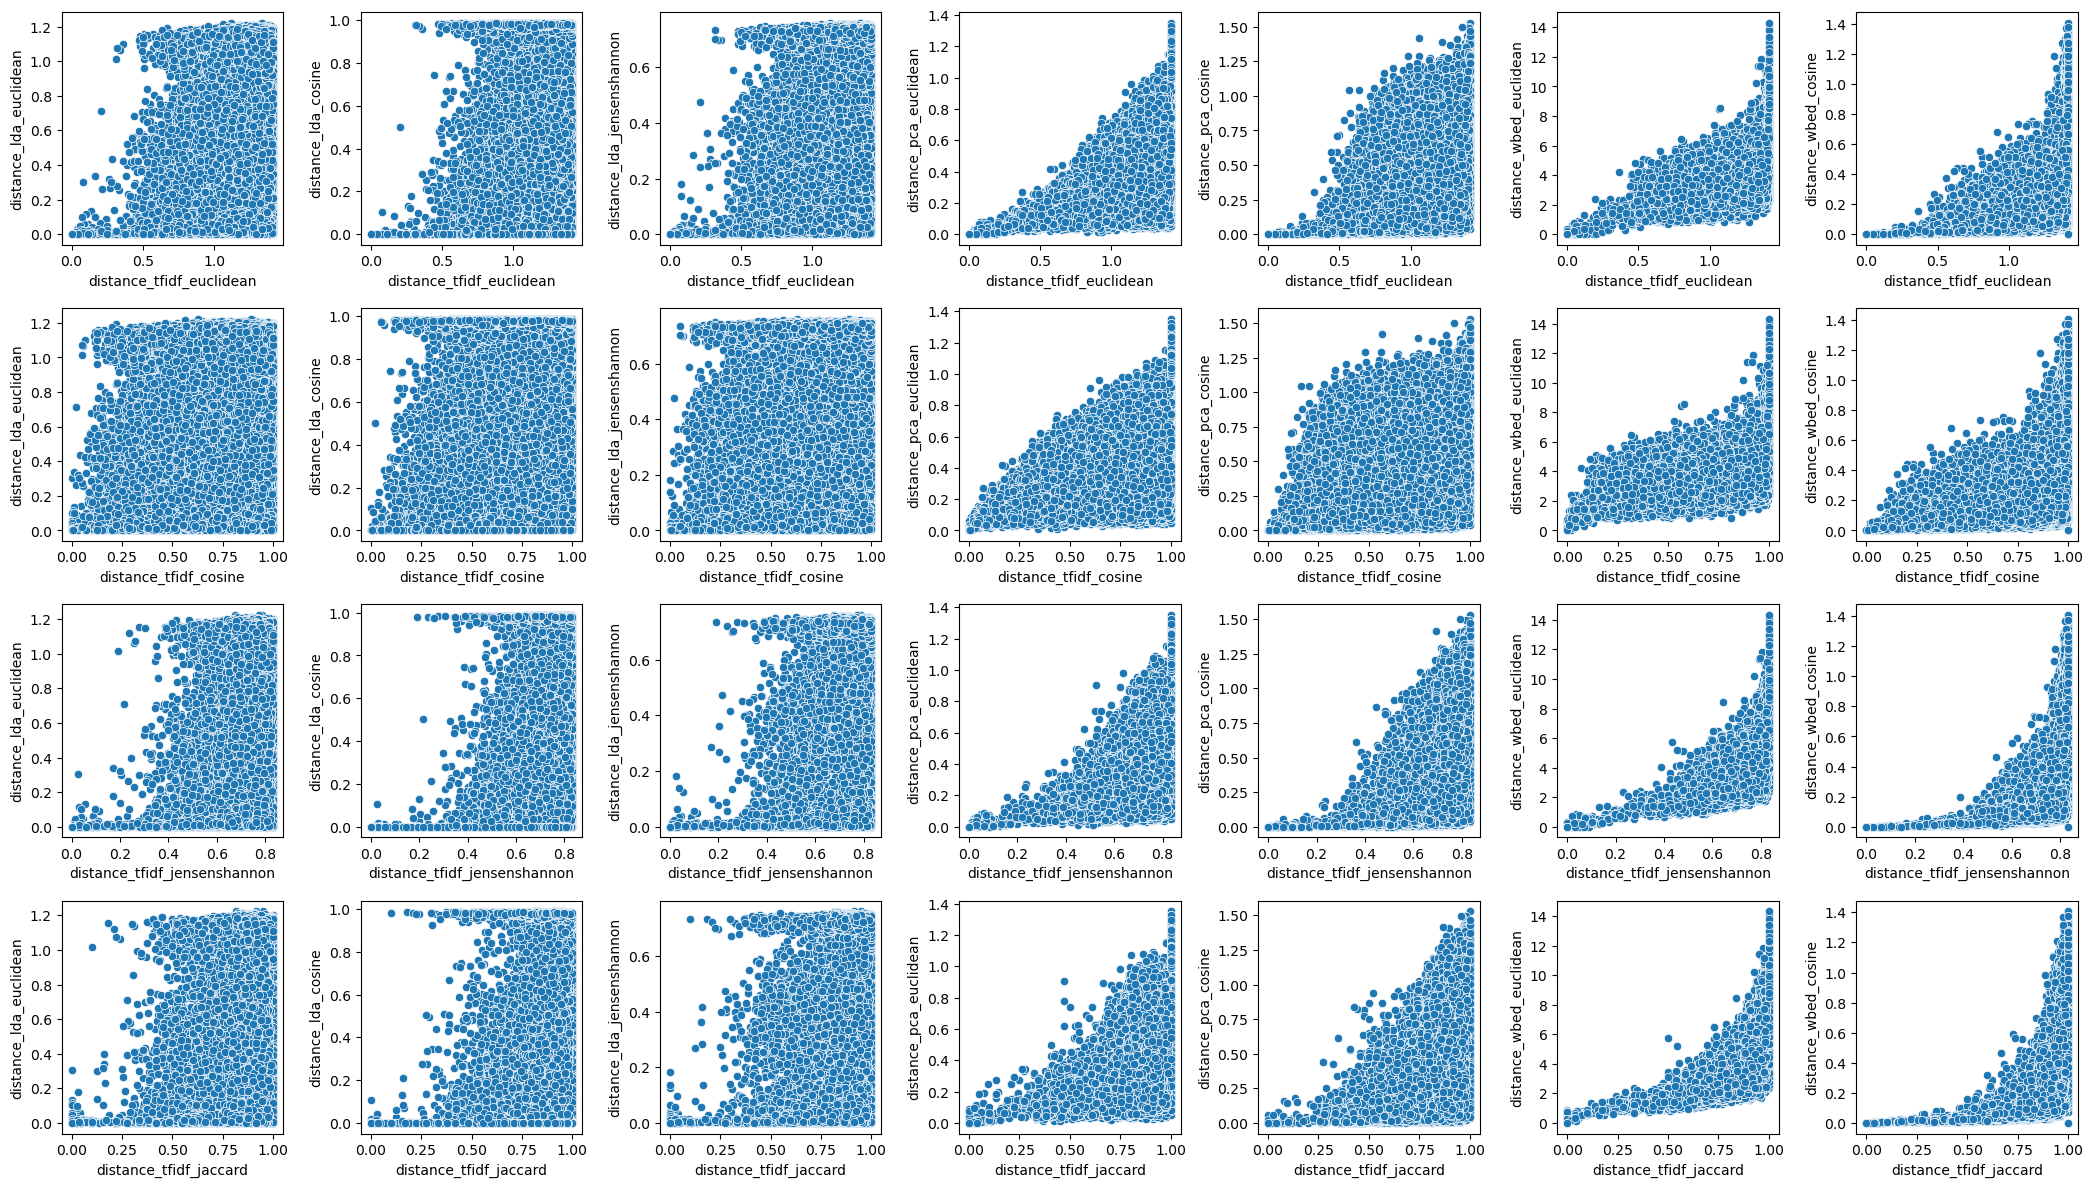

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

x_columns = [
    "distance_tfidf_euclidean", "distance_tfidf_cosine", "distance_tfidf_jensenshannon", "distance_tfidf_jaccard"]

y_columns = [
    "distance_lda_euclidean", "distance_lda_cosine", "distance_lda_jensenshannon",
    "distance_pca_euclidean", "distance_pca_cosine",
    "distance_wbed_euclidean", "distance_wbed_cosine"]

# Create a 4x7 grid of scatter plots
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(21, 12))

for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        sns.scatterplot(data=distance_df_matrix, x=x_col, y=y_col, ax=axes[i, j])
        axes[i, j].set_xlabel(x_col)
        axes[i, j].set_ylabel(y_col)

# Adjust layout for better readability
plt.tight_layout()
plt.savefig(rst_path+'corr_matrix.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

### 4) Find the closest patentand average distance to their citation

In [17]:
columns_to_minimize = numeric_columns
closest_pubnums = {}

for col in columns_to_minimize:
    # Group by 'APPLN_ID_SIPO' and find the index of the minimum value in the current column
    min_indices = distance_df_matrix.groupby('APPLN_ID_SIPO')[col].idxmin()

    # Select the rows with the minium values in the current column
    closest_pubnums_col = distance_df_matrix.loc[min_indices, ['APPLN_ID_SIPO', 'PubNum_google', col]]

    # Set 'APPLN_ID_SIPO' as the index
    closest_pubnums_col.set_index('APPLN_ID_SIPO', inplace=True)

    # Rename the columns
    closest_pubnums_col.columns = [f'PubNum_{col}', f'{col}_min']

    # Store the result in the dictionary
    closest_pubnums[col] = closest_pubnums_col

# Concatenate the data frames in the dictionary
closest_pubnums_combined = pd.concat(closest_pubnums.values(), axis=1)

# Write the concatenated data frame to a CSV file
closest_pubnums_combined.to_csv(rst_path+'closest_pubnums_combined.csv',index= True)

In [34]:
closest_pubnums_combined

,PubNum_distance_lda_euclidean,distance_lda_euclidean_min,PubNum_distance_lda_cosine,distance_lda_cosine_min,PubNum_distance_lda_jensenshannon,distance_lda_jensenshannon_min,PubNum_distance_pca_euclidean,distance_pca_euclidean_min,PubNum_distance_pca_cosine,distance_pca_cosine_min,...,PubNum_distance_wbed_cosine,distance_wbed_cosine_min,PubNum_distance_tfidf_euclidean,distance_tfidf_euclidean_min,PubNum_distance_tfidf_cosine,distance_tfidf_cosine_min,PubNum_distance_tfidf_jensenshannon,distance_tfidf_jensenshannon_min,PubNum_distance_tfidf_jaccard,distance_tfidf_jaccard_min
APPLN_ID_SIPO,,,,,,,,,,,,,,,,,,,,,
CN00100006.3,US4887778,1.005376,US4887778,0.975847,US4887778,0.724962,US6032845A,0.335469,US6032845A,0.487228,...,US4887778,0.191889,US6032845A,1.355085,US6032845A,0.918128,US6032845A,0.780172,US5024720A,0.916667
CN00100115.9,JPH026402A,0.031242,JPH026402A,0.000034,JPH026402A,0.029026,CN1210673A,0.220762,CN1210673A,0.203411,...,JPH10324608A,0.124893,CN1210673A,1.151564,CN1210673A,0.663050,CN1210673A,0.674061,CN1210673A,0.816327
CN00100212.0,JPH097217A,1.096276,JPH097217A,0.978305,JPH097217A,0.711121,JPH097217A,0.241457,JPH097217A,0.780580,...,US5130857A,0.350826,JPH08278477A,1.395291,JPH08278477A,0.973419,JPH08278477A,0.811490,JPH08278477A,0.965517
CN00100269.4,US4650727A,1.141291,US4650727A,0.982464,US4650727A,0.728500,US6296814B,0.228734,US20020168307A1,0.682699,...,JPS6054902A,0.564597,CN1292157A,1.402197,CN1292157A,0.983078,CN1292157A,0.818793,CN1292157A,0.973684
CN00100304.6,EP0549311A1,0.699769,JPS63110003A,0.755529,CN1230924A,0.590311,JPS63110003A,0.203443,JPS63110003A,0.553987,...,EP0635383A1,0.234199,EP0635383A1,1.404307,EP0635383A1,0.986039,EP0635383A1,0.819310,CN1230924A,0.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CN99127338.9,JPS6353288,0.962977,JPS6353288,0.972225,WO2001023458A1,0.706258,JPS60126322A,0.195446,JPS60126322A,0.759097,...,JPS60126322A,0.533441,DD301044A7,1.376488,DD301044A7,0.947360,DD301044A7,0.789960,DD301044A7,0.910714
CN99127570.5,CN1061415A,0.913655,CN1061415A,0.965420,CN1061415A,0.687402,US5604206A,0.371961,WO2000076554A1,1.091911,...,WO2000076554A1,0.611008,CN1513861A,1.402344,CN1513861A,0.983284,CN1513861A,0.819830,CN1061415A,0.972973
CN99801542.3,US5174144A,0.914479,US5174144A,0.949518,US5174144A,0.647133,US5174144A,1.009266,US5174144A,0.946107,...,JPS62137102A,0.000000,JPS62137102A,1.414214,JPS62137102A,1.000000,JPS62137102A,0.832555,JPS62137102A,1.000000


#### Next I want to see how divergent the results are if we calculate the distance using different  methods.

In [64]:
numeric_columns

['distance_lda_euclidean',
 'distance_lda_cosine',
 'distance_lda_jensenshannon',
 'distance_pca_euclidean',
 'distance_pca_cosine',
 'distance_wbed_euclidean',
 'distance_wbed_cosine',
 'distance_tfidf_euclidean',
 'distance_tfidf_cosine',
 'distance_tfidf_jensenshannon',
 'distance_tfidf_jaccard']

In [65]:
# generate the target colums that we are looking at
target_col = []

for item in numeric_columns:
    target_col.append('PubNum_'+item)

In [66]:
# store the results
diff_ratio_dict = dict()

for row in target_col:
    # store the results
    temp_rst = []
    # compare each two columns on how different they are.
    for col in target_col:
        diff_ratio = np.around(np.sum(closest_pubnums_combined[row]!=
                                      closest_pubnums_combined[col])*100/len(closest_pubnums_combined),2)
        temp_rst.append(diff_ratio)
    # store results into a dictionary
    diff_ratio_dict[row] = np.array(temp_rst)

In [67]:
# pack things into a datafram
diff_ratio_df = pd.DataFrame(data = diff_ratio_dict, columns=target_col)
diff_ratio_df.index=target_col
diff_ratio_df

,PubNum_distance_lda_euclidean,PubNum_distance_lda_cosine,PubNum_distance_lda_jensenshannon,PubNum_distance_pca_euclidean,PubNum_distance_pca_cosine,PubNum_distance_wbed_euclidean,PubNum_distance_wbed_cosine,PubNum_distance_tfidf_euclidean,PubNum_distance_tfidf_cosine,PubNum_distance_tfidf_jensenshannon,PubNum_distance_tfidf_jaccard
PubNum_distance_lda_euclidean,0.00,5.48,8.99,57.24,56.80,57.49,57.08,55.80,55.76,55.75,57.42
PubNum_distance_lda_cosine,5.48,0.00,4.72,57.23,56.67,57.55,56.98,55.75,55.69,55.55,57.19
PubNum_distance_lda_jensenshannon,8.99,4.72,0.00,56.92,56.35,57.91,57.08,55.74,55.67,55.53,57.24
PubNum_distance_pca_euclidean,57.24,57.23,56.92,0.00,24.92,53.03,53.77,49.11,49.08,48.76,52.56
PubNum_distance_pca_cosine,56.80,56.67,56.35,24.92,0.00,50.37,49.85,45.13,45.08,43.99,48.47
PubNum_distance_wbed_euclidean,57.49,57.55,57.91,53.03,50.37,0.00,15.65,50.20,50.23,45.92,42.61
PubNum_distance_wbed_cosine,57.08,56.98,57.08,53.77,49.85,15.65,0.00,48.50,47.84,43.45,38.91
PubNum_distance_tfidf_euclidean,55.80,55.75,55.74,49.11,45.13,50.20,48.50,0.00,0.69,19.34,40.08
PubNum_distance_tfidf_cosine,55.76,55.69,55.67,49.08,45.08,50.23,47.84,0.69,0.00,18.94,39.39
PubNum_distance_tfidf_jensenshannon,55.75,55.55,55.53,48.76,43.99,45.92,43.45,19.34,18.94,0.00,26.41


#### Record the data.

In [115]:
closest_pubnums_combined.columns

Index(['PubNum_distance_lda_euclidean', 'distance_lda_euclidean_min',
       'PubNum_distance_lda_cosine', 'distance_lda_cosine_min',
       'PubNum_distance_lda_jensenshannon', 'distance_lda_jensenshannon_min',
       'PubNum_distance_pca_euclidean', 'distance_pca_euclidean_min',
       'PubNum_distance_pca_cosine', 'distance_pca_cosine_min',
       'PubNum_distance_wbed_euclidean', 'distance_wbed_euclidean_min',
       'PubNum_distance_wbed_cosine', 'distance_wbed_cosine_min',
       'PubNum_distance_tfidf_euclidean', 'distance_tfidf_euclidean_min',
       'PubNum_distance_tfidf_cosine', 'distance_tfidf_cosine_min',
       'PubNum_distance_tfidf_jensenshannon',
       'distance_tfidf_jensenshannon_min', 'PubNum_distance_tfidf_jaccard',
       'distance_tfidf_jaccard_min'],
      dtype='object')

In [116]:
# save the closest patent
closest_pubnums = closest_pubnums_combined[['PubNum_distance_lda_euclidean','PubNum_distance_lda_cosine', 
                                            'PubNum_distance_lda_jensenshannon', 
                                            'PubNum_distance_pca_euclidean', 'PubNum_distance_pca_cosine', 
                                            'PubNum_distance_wbed_euclidean', 'PubNum_distance_wbed_cosine', 
                                            'PubNum_distance_tfidf_euclidean', 'PubNum_distance_tfidf_cosine', 
                                            'PubNum_distance_tfidf_jensenshannon','PubNum_distance_tfidf_jaccard']]
closest_pubnums.to_csv(path+'closest_pubnums.csv',index= True)

# save the shortest distance
closest_distances = closest_pubnums_combined[['distance_lda_euclidean_min','distance_lda_cosine_min', 
                                              'distance_lda_jensenshannon_min', 
                                              'distance_pca_euclidean_min', 'distance_pca_cosine_min',
                                              'distance_wbed_cosine_min', 'distance_wbed_euclidean_min', 
                                            'distance_tfidf_euclidean_min','distance_tfidf_cosine_min', 
                                              'distance_tfidf_jensenshannon_min', 'distance_tfidf_jaccard_min']]
closest_distances.to_csv(path+'closest_distances.csv',index= True)

In [118]:
# calculate the average distance of each patent to their citations
columns_to_average = ["distance_lda_euclidean", "distance_lda_cosine", "distance_lda_jensenshannon",
                   "distance_pca_euclidean", "distance_pca_cosine",
                   "distance_wbed_euclidean", "distance_wbed_cosine",
                   "distance_tfidf_euclidean", "distance_tfidf_cosine", "distance_tfidf_jensenshannon", 
                      "distance_tfidf_jaccard"]

grouped_averages = distance_df_combine.groupby('APPLN_ID_SIPO')[columns_to_average].mean()
grouped_averages_ave = grouped_averages.add_suffix('_ave')
grouped_averages_ave = pd.DataFrame(grouped_averages_ave)
grouped_averages_ave.to_csv(path+'grouped_averages_ave.csv',index= True)
grouped_averages_ave

,distance_lda_euclidean_ave,distance_lda_cosine_ave,distance_lda_jensenshannon_ave,distance_pca_euclidean_ave,distance_pca_cosine_ave,distance_wbed_euclidean_ave,distance_wbed_cosine_ave,distance_tfidf_euclidean_ave,distance_tfidf_cosine_ave,distance_tfidf_jensenshannon_ave,distance_tfidf_jaccard_ave
APPLN_ID_SIPO,,,,,,,,,,,
CN00100006.3,1.095835,0.981638,0.736739,0.391977,0.761478,4.040623,0.231335,1.377757,0.949207,0.795849,0.937625
CN00100115.9,0.227617,0.103175,0.161559,0.286574,0.303115,2.838283,0.142534,1.276432,0.818770,0.731910,0.858601
CN00100212.0,1.126120,0.981174,0.723308,0.298485,0.960088,5.588666,0.535380,1.411944,0.996808,0.829235,0.991700
CN00100269.4,1.159911,0.983995,0.736043,0.330505,0.854705,5.314808,0.616312,1.408929,0.992550,0.826201,0.987372
CN00100304.6,0.753174,0.822512,0.624713,0.266445,0.702307,3.931630,0.294416,1.411817,0.996621,0.828201,0.987678
...,...,...,...,...,...,...,...,...,...,...,...
CN99127338.9,1.079946,0.978169,0.715055,0.303211,1.034417,7.231028,0.750691,1.407584,0.990694,0.822012,0.970912
CN99127570.5,0.961482,0.971697,0.703377,0.401846,1.221013,7.139126,0.946510,1.410143,0.994263,0.826547,0.982745
CN99801542.3,0.935068,0.951920,0.658974,1.014092,0.958597,5.616501,0.000000,1.414214,1.000000,0.832555,1.000000


### 5) choose a patent and show the distance network:

In [3]:
# read in the data
distance_df_combine = pd.read_csv(path+'distance_df_combine.csv')
distance_df_combine.sort_values(by=['APPLN_ID_SIPO'], inplace=True)
distance_df_combine.set_index(['APPLN_ID_SIPO', 'PubNum_google'], inplace=True)
distance_df_combine

distance_lda_euclidean  distance_lda_cosine  \
APPLN_ID_SIPO PubNum_google                                                
CN00100006.3  US6619526B1                  1.172795             0.985083   
              US6032845A                   1.023374             0.979819   
              US4887778                    1.005376             0.975847   
              US5024720A                   1.181796             0.985804   
CN00100115.9  JPH10324608A                 0.612815             0.309438   
...                                             ...                  ...   
CN99807511.6  US5260581A                   0.801338             0.939171   
              US4870287A                   0.847244             0.943747   
              CN1161240A                   0.986639             0.957528   
              DE19907771A1                 0.953854             0.954112   
CN99815996.4  JPH1017591A                  0.981795             0.957044   

                             distance_lda_jensenshannon  \
APPLN_ID_SIPO PubNum_google                               
CN00100006.3  US6619526B1                      0.740770   
              US6032845A                       0.737075   
              US4887778                        0.724962   
              US5024720A                       0.744148   
CN00100115.9  JPH10324608A                     0.419908   
...                                                 ...   
CN99807511.6  US5260581A                       0.637139   
              US4870287A                       0.636141   
              CN1161240A                       0.690087   
              DE19907771A1                     0.669755   
CN99815996.4  JPH1017591A                      0.686978   

                             distance_pca_euclidean  distance_pca_cosine  \
APPLN_ID_SIPO PubNum_google                                                
CN00100006.3  US6619526B1                  0.406466             0.810133   
              US6032845A                   0.335469             0.487228   
              US4887778                    0.397147             0.931885   
              US5024720A                   0.428825             0.816665   
CN00100115.9  JPH10324608A                 0.277029             0.348170   
...                                             ...                  ...   
CN99807511.6  US5260581A                   1.028414             0.996769   
              US4870287A                   1.047051             0.982723   
              CN1161240A                   1.037217             1.010314   
              DE19907771A1                 1.034660             1.032928   
CN99815996.4  JPH1017591A                  1.061413             1.014871   

                             distance_wbed_euclidean  distance_wbed_cosine  \
APPLN_ID_SIPO PubNum_google                                                  
CN00100006.3  US6619526B1                   3.753521              0.225774   
              US6032845A                    4.496413              0.290905   
              US4887778                     3.651325              0.191889   
              US5024720A                    4.261232              0.216773   
CN00100115.9  JPH10324608A                  2.482388              0.124893   
...                                              ...                   ...   
CN99807511.6  US5260581A                    5.103778              0.000000   
              US4870287A                    5.038186              0.000000   
              CN1161240A                    4.906307              0.000000   
              DE19907771A1                  5.678179              0.000000   
CN99815996.4  JPH1017591A                   4.324152              0.000000   

                             distance_tfidf_euclidean  distance_tfidf_cosine  \
APPLN_ID_SIPO PubNum_google                                                    
CN00100006.3  US6619526B1                    1.389011               0.964676   
              US6032845A    

In [4]:
# I use the lda euclidean and cosine distance.
distance_df_combine2 = copy.deepcopy(distance_df_combine[['distance_lda_euclidean','distance_lda_cosine']])
distance_df_pair_ave = distance_df_combine2.mean(axis=1)
distance_df_pair_ave = distance_df_pair_ave.to_frame(name='average_distance')
distance_df_pair_ave.reset_index(inplace=True)
distance_df_pair_ave.to_csv(path+'distance_df_pair_ave_tfidf.csv',index= False)
distance_df_pair_ave

,APPLN_ID_SIPO,PubNum_google,average_distance
0,CN00100006.3,US6619526B1,1.078939
1,CN00100006.3,US6032845A,1.001596
2,CN00100006.3,US4887778,0.990611
3,CN00100006.3,US5024720A,1.083800
4,CN00100115.9,JPH10324608A,0.461127
...,...,...,...
262959,CN99807511.6,US5260581A,0.870254
262960,CN99807511.6,US4870287A,0.895496
262961,CN99807511.6,CN1161240A,0.972084
262962,CN99807511.6,DE19907771A1,0.953983


In [23]:
import ipywidgets as widgets
from IPython.display import display

def plot_graph(appln_id_sipo):
    selected_rows = distance_df_pair_ave[distance_df_pair_ave['APPLN_ID_SIPO'] == appln_id_sipo]
    
    # Create an empty graph
    G = nx.Graph()

    # Add edges to the graph from the DataFrame
    for _, row in selected_rows.iterrows():
        G.add_edge(row['APPLN_ID_SIPO'], row['PubNum_google'], weight=row['average_distance'])

    # Draw the network graph
    plt.figure(figsize=(8,8))
    pos = nx.kamada_kawai_layout(G, weight='weight')

    # Extract edge weights from the graph
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Draw the graph with edge widths based on weights
    nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=100)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos)

    # Display the graph
    plt.axis('off')
    plt.show()

In [26]:
# draw an interactive graph
appln_id_sipo_values = ['CN00100006.3', 'CN99807511.6','CN99815996.4']

dropdown = widgets.Dropdown(
    options=appln_id_sipo_values,
    value=appln_id_sipo_values[0],
    description='APPLN_ID_SIPO:',
)

interactive_plot = widgets.interactive(plot_graph, appln_id_sipo=dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='APPLN_ID_SIPO:', options=('CN00100006.3', 'CN99807511.6', 'CN99815…